The objective of this post is to compare two models (Cox proportional hazards model and Random survival forest model) to estimate the survival probability given a set of features/covariables.

>["Experimental Comparison of Semi-parametric, Parametric, and Machine Learning Models for Time-to-Event Analysis Through the Concordance Index,"](https://arxiv.org/abs/2003.08820)
Camila Fernandez, Chung Shue Chen, Pierre Gaillard, Alonso Silva

To perform this analysis we will use [scikit-learn](https://scikit-learn.org/) and [scikit-survival](https://pypi.org/project/scikit-survival/). Finally, we will use [eli5](https://eli5.readthedocs.io/en/latest/index.html) to study feature importances (computed with permutation importance).

```console
$ conda install scikit-learn
$ conda install -c sebp scikit-survival
$ conda install -c conda-forge eli5
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

We first download a dataset from scikit-survival.

In [2]:
from sksurv.datasets import load_gbsg2

X, y = load_gbsg2()

## An example: German Breast Cancer Study Group 2 (gbcsg)

This dataset contains the following 8 features/covariables:

- age: age (in years), 
- estrec: estrogen receptor (in fmol), 
- horTh: hormonal therapy (yes or no), 
- menostat: menopausal status (premenopausal or postmenopausal),
- pnodes: number of positive nodes, 
- progrec: progesterone receptor (in fmol), 
- tgrade: tumor grade (I < II < III), 
- tsize: tumor size (in mm).

and the two outputs: 

- recurrence free time (in days),
- censoring indicator (0 - censored, 1 - event).

The dataset has 686 samples and 8 features/covariables.


**References**

M. Schumacher, G. Basert, H. Bojar, K. Huebner, M. Olschewski, W. Sauerbrei, C. Schmoor, C. Beyerle, R.L.A. Neumann and H.F. Rauschecker for the German Breast Cancer Study Group (1994), [Randomized 2 x 2 trial evaluating hormonal treatment and the duration of chemotherapy in node-positive breast cancer patients](https://www.ncbi.nlm.nih.gov/pubmed/7931478). Journal of Clinical Oncology, 12, 2086–2093.

Let's take a look at the features/covariates.

In [3]:
X.head(10).style.hide_index()

age,estrec,horTh,menostat,pnodes,progrec,tgrade,tsize
70.000000,66.000000,no,Post,3.000000,48.000000,II,21.000000
56.000000,77.000000,yes,Post,7.000000,61.000000,II,12.000000
58.000000,271.000000,yes,Post,9.000000,52.000000,II,35.000000
59.000000,29.000000,yes,Post,4.000000,60.000000,II,17.000000
73.000000,65.000000,no,Post,1.000000,26.000000,II,35.000000
32.000000,13.000000,no,Pre,24.000000,0.000000,III,57.000000
59.000000,0.000000,yes,Post,2.000000,181.000000,II,8.000000
65.000000,25.000000,no,Post,1.000000,192.000000,II,16.000000
80.000000,59.000000,no,Post,30.000000,0.000000,II,39.000000
66.000000,3.000000,no,Post,7.000000,0.000000,II,18.000000


Let's take a look at the output.

In [4]:
y[:10]

array([( True, 1814.), ( True, 2018.), ( True,  712.), ( True, 1807.),
       ( True,  772.), ( True,  448.), (False, 2172.), (False, 2161.),
       ( True,  471.), (False, 2014.)],
      dtype=[('cens', '?'), ('time', '<f8')])

For the output, scikit-survival uses a numpy nd array, so to show it we do a dataframe.

In [5]:
df_y = pd.DataFrame(data={'time': [y[i][1] for i in range(len(y))], 'event': [y[i][0] for i in range(len(y))]})
df_y[:10].style.hide_index().highlight_min('event', color='lightgreen')

time,event
1814.000000,True
2018.000000,True
712.000000,True
1807.000000,True
772.000000,True
448.000000,True
2172.000000,False
2161.000000,False
471.000000,True
2014.000000,False


One of the main challenges of survival analysis is **right censoring**, i.e., by the end of the study, the event of interest (for example, in medicine 'death of a patient' or in this dataset 'recurrence of cancer') has only occurred for a subset of the observations.

The **right censoring** in this dataset is given by the column named 'event' and it's a variable which can take value 'True' if the patient had a recurrence of cancer or 'False' if the patient is recurrence free at the indicated time (right-censored samples).

Let's see how many right-censored samples do we have.

In [6]:
print(f'Number of samples: {len(df_y)}')
print(f'Number of right censored samples: {len(df_y.query("event == False"))}')
print(f'Percentage of right censored samples: {100*len(df_y.query("event == False"))/len(df_y):.1f}%')

Number of samples: 686
Number of right censored samples: 387
Percentage of right censored samples: 56.4%


There are 387 patients (56.4%) who were right censored (recurrence free) at the end of the study.

Let's divide our dataset in training and test sets.

In [7]:
from sklearn.model_selection import train_test_split

X_trn, X_test, y_trn, y_test = train_test_split(X, y, random_state=42)

print(f'Number of training samples: {len(y_trn)}')
print(f'Number of test samples: {len(y_test)}')

Number of training samples: 514
Number of test samples: 172


We divide the features/covariates into continuous and categorical.

In [8]:
scaling_cols = [c for c in X.columns if X[c].dtype.kind in ['i', 'f']]
cat_cols = [c for c in X.columns if X[c].dtype.kind not in ["i", "f"]]

We use ordinal encoding for categorical features/covariates and standard scaling for continuous features/covariates.

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

preprocessor = ColumnTransformer(
    [('cat-preprocessor', OrdinalEncoder(), cat_cols),
    ('standard-scaler', StandardScaler(), scaling_cols)],
    remainder='passthrough', sparse_threshold=0)

# Baseline: Cox Proportional Hazards model

Cox Proportional Hazards model assumes that the log-hazard of a subject is a linear function of their $m$ static covariates/features $h_i, i\in\{1,\ldots,m\}$, and a population-level baseline hazard function $h_0(t)$ that changes over time:
\begin{equation}
h(t|x)=h_0(t)\exp\left(\sum_{i=1}^mh_i(x_i-\bar{x_i})\right).
\end{equation}

The term *proportional hazards* refers to the assumption of a constant relationship between the dependent variable and the regression coefficients.

In [10]:
from sklearn.pipeline import make_pipeline
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

cox = make_pipeline(preprocessor, CoxPHSurvivalAnalysis())
cox.fit(X_trn, y_trn)

ci_cox = concordance_index_censored(y_test["cens"], y_test["time"], cox.predict(X_test))
print(f'The c-index of Cox is given by {ci_cox[0]:.3f}')

The c-index of Cox is given by 0.635


In [11]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'coxphsurvivalanalysis__alpha': reciprocal(0.1, 100),
}

model_random_search = RandomizedSearchCV(
    cox, param_distributions=param_distributions, n_iter=50, n_jobs=-1, cv=3, random_state=42)
model_random_search.fit(X_trn, y_trn)

print(
    f"The c-index of Cox using a {model_random_search.__class__.__name__} is "
    f"{model_random_search.score(X_test, y_test):.3f}")
print(
    f"The best set of parameters is: {model_random_search.best_params_}"
)

The c-index of Cox using a RandomizedSearchCV is 0.646
The best set of parameters is: {'coxphsurvivalanalysis__alpha': 31.428808908401084}


In [12]:
alpha = model_random_search.best_params_['coxphsurvivalanalysis__alpha']
cox_best = make_pipeline(preprocessor, CoxPHSurvivalAnalysis(alpha=alpha))
cox_best.fit(X_trn, y_trn)

ci_cox = concordance_index_censored(y_test["cens"], y_test["time"], cox_best.predict(X_test))
print(f'The c-index of Cox is given by {ci_cox[0]:.3f}')

The c-index of Cox is given by 0.646


In [13]:
from eli5.sklearn import PermutationImportance

/Users/alonsosilva/opt/anaconda3/envs/survival/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/alonsosilva/opt/anaconda3/envs/survival/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [14]:
perm = PermutationImportance(
    cox_best.steps[-1][1], n_iter=100).fit(preprocessor.fit_transform(X_trn),y_trn)

In [15]:
data = perm.results_
data = pd.DataFrame(data, columns=X_trn.columns)
meds = data.median()
meds = meds.sort_values(ascending=False)
data = data[meds.index]

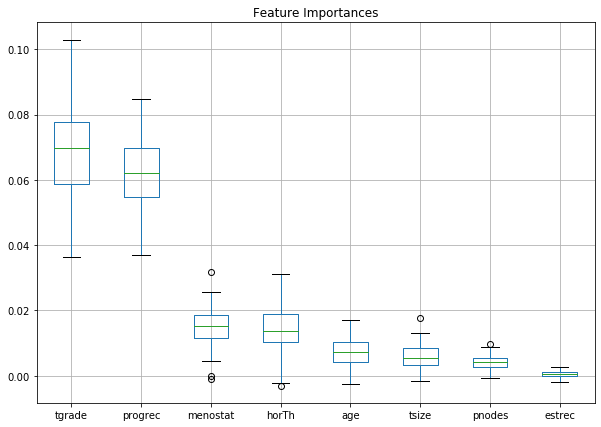

In [16]:
fig, ax = plt.subplots(figsize=(10,7))
data.boxplot(ax=ax)
ax.set_title('Feature Importances')
plt.show()

In [17]:
import eli5
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.0691 ± 0.0273,tgrade
0.0626 ± 0.0210,progrec
0.0152 ± 0.0112,menostat
0.0141 ± 0.0127,horTh
0.0072 ± 0.0089,age
0.0059 ± 0.0074,tsize
0.0040 ± 0.0040,pnodes
0.0006 ± 0.0018,estrec


# Random Survival Forest model

The random survival forest model, proposed by Ishwaran et al. (2008), is an extension of the random forest model, introduced by Breiman et al. (2001), that can take into account censoring. The randomness is introduced in two ways, first we use bootstrap samples of the dataset to grow the trees and second, at each node of the tree, we randomly choose a subset of variables as candidates for the split. The quality of a split is measured by the log-rank splitting rule. Then, we average the trees results which allows us to improve the accuracy and avoid overfitting.

In [18]:
from sksurv.ensemble import RandomSurvivalForest

rsf = make_pipeline(preprocessor, RandomSurvivalForest(random_state=42))
rsf.fit(X_trn, y_trn)
ci_rsf = concordance_index_censored(y_test["cens"], y_test["time"], rsf.predict(X_test))
print(f'The c-index of Random Survival Forest is given by {ci_rsf[0]:.3f}')

The c-index of Random Survival Forest is given by 0.658


In [19]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

class reciprocal_int:
    def __init__(self, a, b):
        self._distribution = reciprocal(a, b)

    def rvs(self, *args, **kwargs):
        return self._distribution.rvs(*args, **kwargs).astype(int)

param_distributions1 = {
    'randomsurvivalforest__max_features': reciprocal_int(3, 8),
    'randomsurvivalforest__max_depth': reciprocal_int(5, 50),
    'randomsurvivalforest__min_samples_leaf': reciprocal_int(1, 40),
}

model_random_search = RandomizedSearchCV(
    rsf, param_distributions=param_distributions1, n_iter=50, n_jobs=-1, cv=3, random_state=0)
model_random_search.fit(X_trn, y_trn)

print(
    f"The c-index of random survival forest using a {model_random_search.__class__.__name__} is "
    f"{model_random_search.score(X_test, y_test):.3f}")
print(
    f"The best set of parameters is: {model_random_search.best_params_}"
)

The c-index of random survival forest using a RandomizedSearchCV is 0.640
The best set of parameters is: {'randomsurvivalforest__max_depth': 23, 'randomsurvivalforest__max_features': 3, 'randomsurvivalforest__min_samples_leaf': 1}


In [20]:
max_depth = model_random_search.best_params_['randomsurvivalforest__max_depth']
max_features = model_random_search.best_params_['randomsurvivalforest__max_features']
min_samples_leaf = model_random_search.best_params_['randomsurvivalforest__min_samples_leaf']

In [21]:
rsf_best = make_pipeline(preprocessor, RandomSurvivalForest(random_state=42, max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples_leaf))
rsf_best.fit(X_trn, y_trn)
ci_rsf = concordance_index_censored(y_test["cens"], y_test["time"], rsf_best.predict(X_test))
print(f'The c-index of Random Survival Forest is given by {ci_rsf[0]:.3f}')

The c-index of Random Survival Forest is given by 0.640


In [22]:
perm = PermutationImportance(
    rsf.steps[-1][1], n_iter=100).fit(preprocessor.fit_transform(X_trn),y_trn)

In [23]:
data = perm.results_
data = pd.DataFrame(data, columns=X_trn.columns)
meds = data.median()
meds = meds.sort_values(ascending=False)
data = data[meds.index]

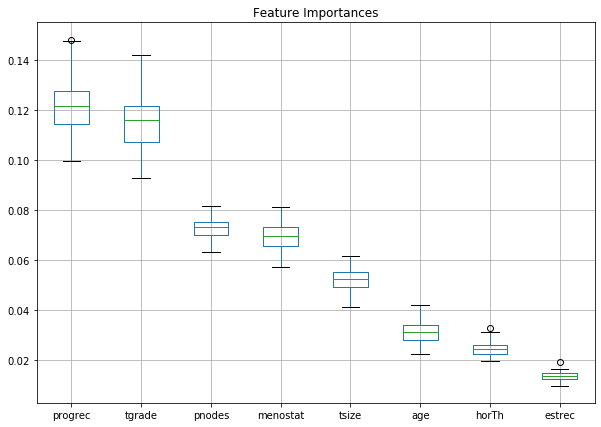

In [24]:
fig, ax = plt.subplots(figsize=(10,7))
data.boxplot(ax=ax)
ax.set_title('Feature Importances')
plt.show()

In [25]:
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.1218 ± 0.0212,progrec
0.1149 ± 0.0195,tgrade
0.0723 ± 0.0087,pnodes
0.0695 ± 0.0106,menostat
0.0521 ± 0.0090,tsize
0.0312 ± 0.0084,age
0.0243 ± 0.0055,horTh
0.0134 ± 0.0034,estrec


In [26]:
# choose random seeds
np.random.seed(0)
seeds = np.random.permutation(1000)[:25]

In [27]:
cox_scores = []
rsf_scores = []
for _seed in seeds:
    X_trn, X_test, y_trn, y_test = train_test_split(X, y, random_state=_seed)
  
    cox_best = make_pipeline(preprocessor, CoxPHSurvivalAnalysis(alpha=alpha))
    cox_best.fit(X_trn, y_trn)
    ci_cox = concordance_index_censored(y_test["cens"], y_test["time"], cox_best.predict(X_test))
    cox_scores.append(ci_cox[0])

    rsf = make_pipeline(preprocessor, RandomSurvivalForest(random_state=42))
    rsf.fit(X_trn, y_trn)
    ci_rsf = concordance_index_censored(y_test["cens"], y_test["time"], rsf.predict(X_test))
    rsf_scores.append(ci_rsf[0])

In [28]:
print(f'Cox proportional hazards model: Mean c-index: {np.mean(cox_scores):.3f}, standard deviation: {np.std(cox_scores):.3f}')
print(f'Random Survival Forest model: Mean c-index: {np.mean(rsf_scores):.3f}, standard deviation: {np.std(rsf_scores):.3f}')

Cox proportional hazards model: Mean c-index: 0.676, standard deviation: 0.031
Random Survival Forest model: Mean c-index: 0.694, standard deviation: 0.028


In [29]:
data = {'Cox PH': cox_scores, 'Random Survival Forest': rsf_scores}

In [30]:
data = pd.DataFrame(data)

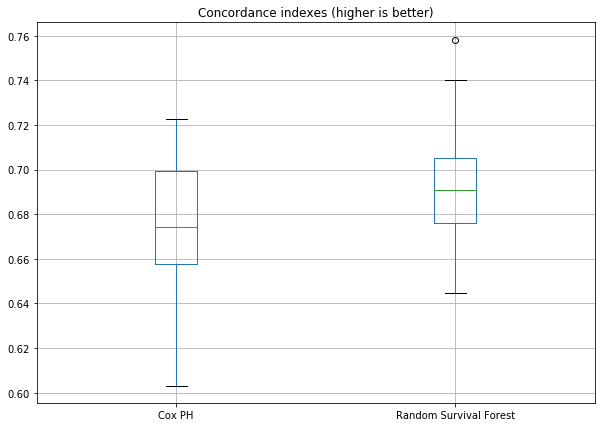

In [31]:
fig, ax = plt.subplots(figsize=(10,7))
data.boxplot(ax=ax)
ax.set_title('Concordance indexes (higher is better)')
plt.show()